In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import colors, ticker

from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)

from tqdm.notebook import tqdm


def collect_data(path, hearts, n_radial, n_angular, node_step, files=[]):

    property_columns = ['area',
                        'major_axis_length',
                        'minor_axis_length',
                        'orientation',
                        'centroid-0',
                        'centroid-1']
    hearts_props = {'Stats': [],
                    'StatsDS': [],
                    'StatsGenerated': []}
    
    loc_bins=np.linspace(0, n_angular * n_radial, n_radial + 1)
    loc_labels=['SUB-ENDO', 'MID', 'SUB-EPI']

    for heart in hearts[:]:
        path_ = path.joinpath(heart, 'Stats')
        
        files = list(path_.glob('*{}'.format('.pkl')))
        files = sorted([file.stem for file in files if not file.name.startswith('.')])

        for slice_name in tqdm(files[:]):
            # Load slice and build HeartSlice object
            try:
                heart_slice_builder = HeartSliceBuilder()
                heart_slice_builder.build_from_file(path, 
                                                    heart, 
                                                    slice_name,
                                                    n_angular,
                                                    n_radial, 
                                                    node_step)
                heart_slice = heart_slice_builder.heart_slice
            except ValueError as e:
                print(heart, slice_name)
                continue

            for subdir in ['Stats', 'StatsDS', 'StatsGenerated']:
                path_slice_stats = path.joinpath(heart, subdir, slice_name)
                stats_loader = StatsLoader(path, subdir, property_columns)
                object_stats = stats_loader.load_slice_data(path_slice_stats)

                # Build objects properties
                objects_props_builder = ObjectsPropertiesBuilder()
                objects_props_builder.build_from_stats(object_stats)
                objects_props_builder.add_slice_props(heart_slice)
                objects_props = objects_props_builder.objects_props

                # Build segment properties
                segments_props_builder = SegmentsPropertiesBuilder()
                segments_props_builder.build(heart_slice, objects_props)
                props = segments_props_builder.props

                props['location'] = pd.cut(props['segment_labels'],
                                           bins=loc_bins,
                                           labels=loc_labels)
                props['heart'] = heart
                hearts_props[subdir].append(props)
            
    hearts_props_or = pd.concat(hearts_props['Stats'], ignore_index=True)
    hearts_props_ds = pd.concat(hearts_props['StatsDS'], ignore_index=True)
    hearts_props_gen = pd.concat(hearts_props['StatsGenerated'], ignore_index=True)
    return hearts_props_or, hearts_props_ds, hearts_props_gen


In [6]:
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')

hearts = ['E10691_RBM20', 'E11444_LMNA', 'E10927_MYBPC3']
# hearts = ['E11444_LMNA']

n_angular = 12
n_radial = 3
node_step = 3

data, data_ds, data_gen = collect_data(path, hearts, n_radial, n_angular, node_step)

  0%|          | 0/18 [00:00<?, ?it/s]

/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough

  0%|          | 0/19 [00:00<?, ?it/s]

/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough

  0%|          | 0/15 [00:00<?, ?it/s]

/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')
/Users/arstanbek/Projects/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough

### SA

In [8]:
data['source'] = 'Histological'
data_gen['source'] = 'Uniform Generator'
data_ds['source'] = 'Direct Sampling'
data_all = pd.concat([data, data_ds, data_gen], ignore_index=True)

/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_1492/2953212359.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_1492/2953212359.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_1492/2953212359.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


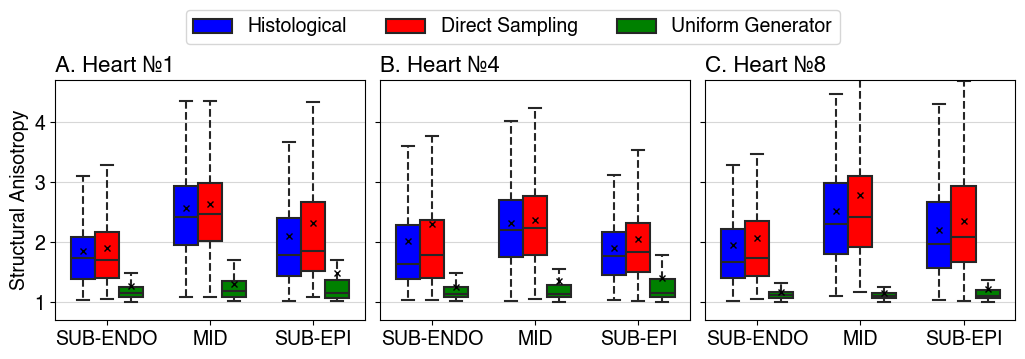

In [15]:
import seaborn as sns
import matplotlib.patches as mpatches
plt.rc('font', family='Helvetica')

titles = ['A', 'B', 'C']
heart_labels = [f'Heart №{i}' for i in [1, 4, 8]]
COLORS = {'Histological': 'blue',
          'Uniform Generator': 'green', 
          'Direct Sampling': 'red'}

fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)

for i, heart in enumerate(hearts):
    ax = axs[i]
    df = data_all[data_all['heart'] == heart]
    sns.boxplot(data=df, y='structural_anisotropy', x='location', hue='source',
                order=['SUB-ENDO', 'MID', 'SUB-EPI'],
                hue_order=['Histological', 'Direct Sampling', 'Uniform Generator'],
                ax=ax, palette=COLORS, linewidth=1, saturation=1,
                showfliers=False, showmeans=True, meanline=False,
                whiskerprops=dict(linewidth=1.5, linestyle='--'),
                boxprops=dict(linewidth=1.5),
                capprops=dict(linewidth=1.5),
                medianprops=dict(linewidth=1.5),
                meanprops=dict(linewidth=1.5, marker='x', markersize=5,
                               markerfacecolor='black', markeredgecolor='black'),
                flierprops=dict(marker='o', markersize=5, 
                                markerfacecolor='black',
                                markeredgecolor='black',),
                width=0.7,
                gap=.0)


    # for violin in ax.collections[::2]:
    #     violin.set_alpha(0.5)
        
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_ylim(0.7, 4.7)

    # ax.set_xticklabels(heart_labels, fontsize=10)
    # plt.xticks(rotation=45)

    ax.legend_.remove()

    ax.grid(axis='y', linestyle='-', alpha=0.5)
    ax.set_ylabel('', fontsize=14)

axs[0].set_yticks(np.arange(1, 5, 1))
axs[0].set_yticklabels(axs[0].get_yticks(), fontsize=14)

axs[0].set_title('A. Heart №1', fontsize=16, loc='left')
axs[1].set_title('B. Heart №4', fontsize=16, loc='left')
axs[2].set_title('C. Heart №8', fontsize=16, loc='left')

axs[0].set_ylabel('Structural Anisotropy', fontsize=14)
fig.legend(handles=axs[0].get_legend_handles_labels()[0],
           labels=axs[0].get_legend_handles_labels()[1],
           loc='upper center', ncol=3, prop={'size': 14})
# fig.legend(loc='upper center', ncol=3, prop={'size': 10})
plt.subplots_adjust(top=0.8,
                    bottom=0.2,
                    left=0.1,
                    right=0.9,
                    hspace=0.1,
                    wspace=0.05)
plt.show()

In [16]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('structural_anisotropy.png'),
            dpi=300, bbox_inches='tight')

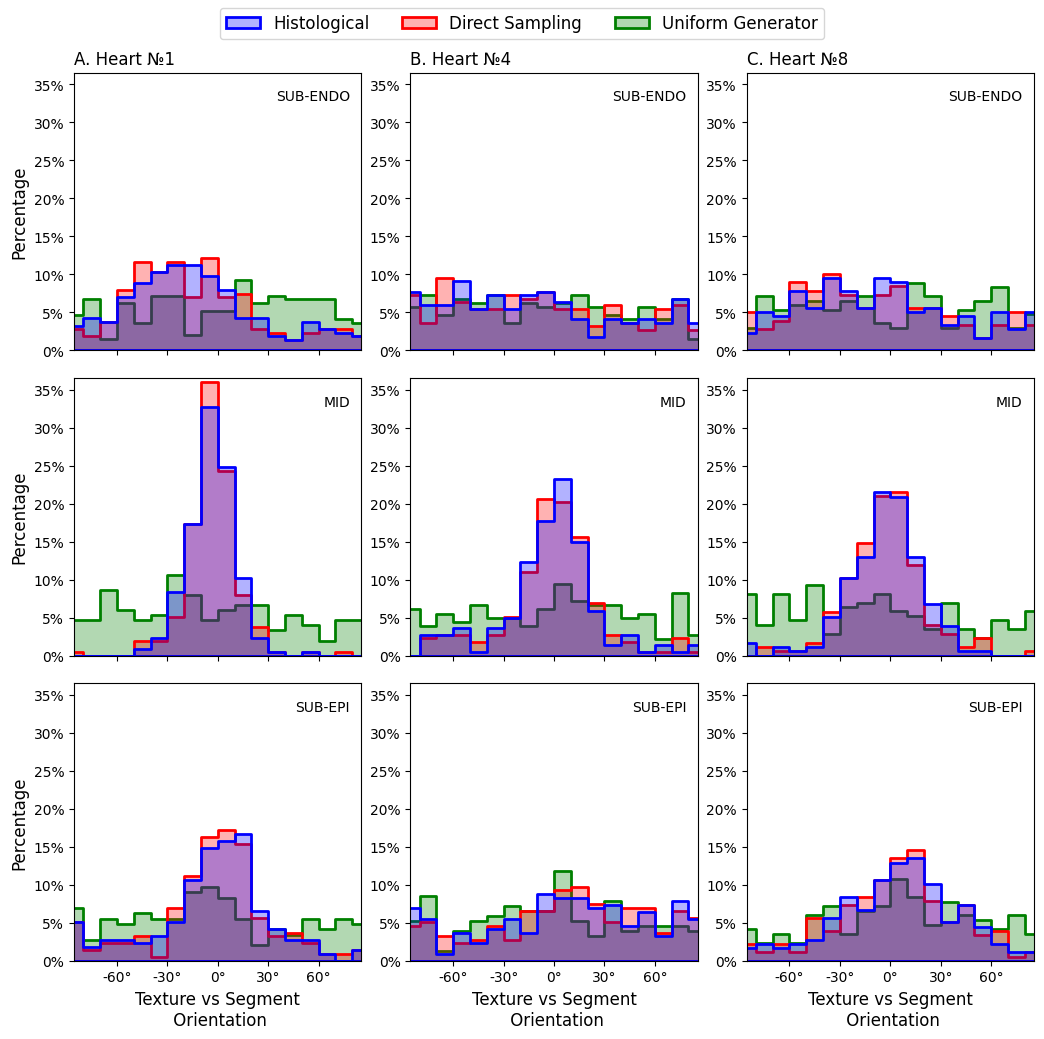

In [37]:
from matplotlib.colors import to_rgba


def degrees_formatter(x, pos):
    return f'{x * 180 / np.pi:.0f}°'


titles = ['A', 'B', 'C']

COLORS = ['blue', 'red', 'green']
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(12, 12),
                        sharex=True)

for i, heart in enumerate(hearts):
    axs[0, i].set_title(f'{titles[i]}. {heart_labels[i]}',
                        fontsize=12, loc='left')
    axs[-1, i].set_xlabel('Texture vs Segment\n Orientation', fontsize=12)

    # for j, df in enumerate([data, data_ds, data_gen]):

    for l, location in enumerate(['SUB-ENDO', 'MID', 'SUB-EPI']):

        ax = axs[l, i]

        ddf = data_all[(data_all['heart'] == heart) & (data_all['location'] == location)]
        sns.histplot(data=ddf, x='relative_orientation', hue='source',
                     hue_order=['Histological', 'Direct Sampling', 'Uniform Generator'],
                     bins=np.linspace(-90, 90, 19) / 180 * np.pi, 
                     ax=ax, stat='percent',
                     common_norm=False, palette=COLORS, alpha=0.3,
                     multiple="layer",
                     element='step',
                     legend=False,
                     linewidth=2)
        ax.annotate(location, xy=(0.96, 0.9), xycoords='axes fraction',
                    fontsize=10, ha='right')
        ax.set_xlim([-0.95 * np.pi/2, 0.95 * np.pi/2])
        # ax.set_title(f'{heart}-{location}')
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(degrees_formatter))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100,
                                                            decimals=0))
        
        # ax.set_yticks([0, 10, 20, 30])
        ax.set_ylim(0, 36.5)
        ax.set_xticks(np.arange(-60, 70, 30) / 180 * np.pi)
        ax.set_ylabel('')

for i in range(3):
    axs[i, 0].set_ylabel('Percentage', fontsize=12)

fig.legend(handles=[mpatches.Patch(edgecolor=COLORS[i],
                                   facecolor=to_rgba(COLORS[i], alpha=0.3),
                                   lw=2,
                                   label=l) for i, l in enumerate(['Histological', 
                                                                   'Direct Sampling',
                                                                   'Uniform Generator'])],
           loc='upper center', ncol=3, prop={'size': 12})
# fig.legend(loc='upper center', ncol=3, prop={'size': 10})
plt.subplots_adjust(top=0.94,
                    bottom=0.2,
                    left=0.1,
                    right=0.9,
                    hspace=0.1,
                    wspace=0.17)
# fig.legend(handles=[mpatches.Patch(color=COLORS[l], 
#                                    label=l) for l in ['SUB-ENDO', 'MID', 
#                                                       'SUB-EPI']],
        #    loc='upper center', ncol=3, prop={'size': 10})
plt.show()

In [38]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('structural_orientation.png'),
            dpi=300, bbox_inches='tight')

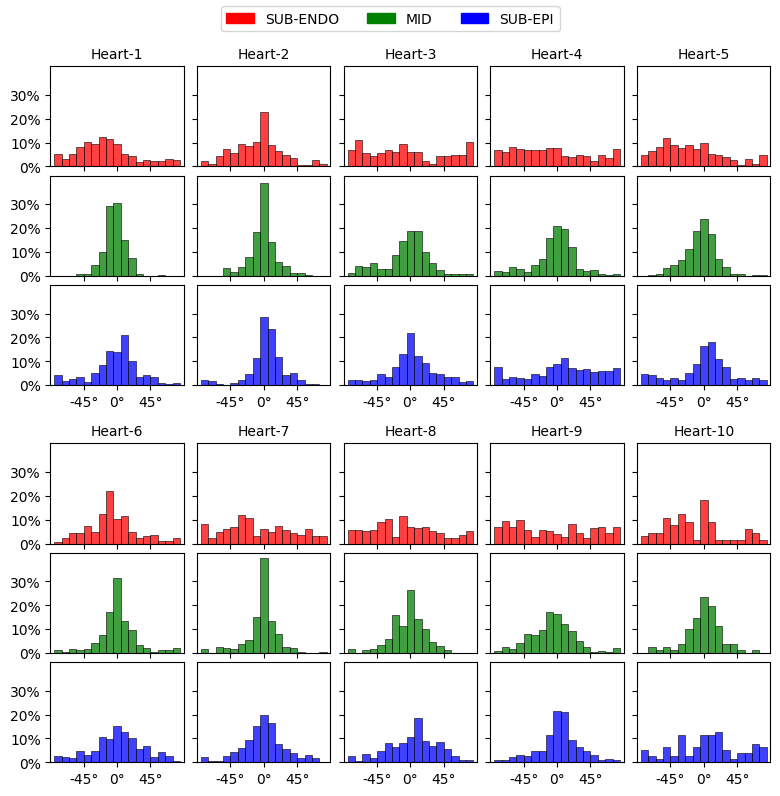

In [134]:
def degrees_formatter(x, pos):
    return f'{x * 180 / np.pi:.0f}°'


fig, axs = plt.subplots(ncols=5, nrows=7, figsize=(8, 8),
                        sharey=True, 
                        height_ratios=[1, 1, 1, 0.4, 1, 1, 1])

for i, heart in enumerate(heart_labels[:]):
    axs[4 * (i // 5), i % 5].set_title(heart, fontsize=10)

    for j, location in enumerate(['SUB-ENDO', 'MID', 'SUB-EPI']):

        if i >= 5:
            ax = axs[j + 4, i % 5]
        else:
            ax = axs[j, i]

        df = data[(data['heart_label'] == heart) & (data['location'] == location)]
        sns.histplot(x=df['relative_orientation'].values,
                     bins=np.arange(-85, 95, 10) / 180 * np.pi, 
                     ax=ax, color=COLORS[location], stat='percent')
        ax.set_xlim([-np.pi/2, np.pi/2])
        # ax.set_title(f'{heart}-{location}')
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(degrees_formatter))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100,
                                                             decimals=0))
         
        ax.set_yticks([0, 10, 20, 30])
        ax.set_xticks([-np.pi/4, 0, np.pi/4])
        ax.set_ylabel('')

for i in range(5):
    axs[3, i].axis('off')
    for j in [0, 1, 4, 5]:
        axs[j, i].set_xticklabels([])

plt.subplots_adjust(top=0.92, 
                    bottom=0.05, 
                    left=0.05, 
                    right=0.95, 
                    hspace=0.1,
                    wspace=0.1)
fig.legend(handles=[mpatches.Patch(color=COLORS[l], 
                                   label=l) for l in ['SUB-ENDO', 'MID', 
                                                      'SUB-EPI']],
           loc='upper center', ncol=3, prop={'size': 10})
plt.show()

In [135]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('structural_orientation.png'),
            dpi=300, bbox_inches='tight')

In [21]:
data_all.groupby(['source', 'heart', 'location']).describe()['structural_anisotropy']

/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_1945/2575376317.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_all.groupby(['source', 'heart', 'location']).describe()['structural_anisotropy']


count      mean       std       min  \
source            heart         location                                        
Direct Sampling   E10691_RBM20  SUB-ENDO  214.0  1.940591  0.804345  1.021040   
                                MID       214.0  2.667612  0.901965  1.045330   
                                SUB-EPI   215.0  2.315845  1.392870  1.083530   
                  E10927_MYBPC3 SUB-ENDO  178.0  2.174936  1.176438  1.066732   
                                MID       175.0  2.804979  1.187784  1.119056   
                                SUB-EPI   178.0  2.502938  1.127987  1.015324   
                  E11444_LMNA   SUB-ENDO  217.0  2.246885  1.536556  1.043532   
                                MID       216.0  2.460320  0.981278  1.054741   
                                SUB-EPI   215.0  2.099330  0.928351  1.037829   
Histological      E10691_RBM20  SUB-ENDO  214.0  1.851636  0.692252  1.030611   
                                MID       214.0  2.572143  0.952358  1.099444   
                                SUB-EPI   215.0  2.118642  1.193338  1.022988   
                  E10927_MYBPC3 SUB-ENDO  178.0  1.961028  0.875811  1.015182   
                                MID       177.0  2.527356  0.991751  1.100668   
                                SUB-EPI   178.0  2.208970  0.862978  1.040804   
                  E11444_LMNA   SUB-ENDO  220.0  2.022192  1.273660  1.048459   
                                MID       220.0  2.329014  0.919149  1.025464   
                                SUB-EPI   217.0  1.904720  0.664724  1.032138   
Uniform Generator E10691_RBM20  SUB-ENDO  194.0  1.266056  0.426016  1.011150   
                                MID       151.0  1.310072  0.416643  1.016671   
                                SUB-EPI   144.0  1.500136  1.614045  1.013708   
                  E10927_MYBPC3 SUB-ENDO  169.0  1.166646  0.173720  1.001149   
                                MID       172.0  1.142389  0.158938  1.006683   
                                SUB-EPI   167.0  1.217759  0.525859  1.007352   
                  E11444_LMNA   SUB-ENDO  192.0  1.247722  0.438103  1.012267   
                                MID       181.0  1.357434  0.814179  1.005967   
                                SUB-EPI   153.0  1.411507  0.718190  1.005672   

                                               25%       50%       75%  \
source            heart         location                                 
Direct Sampling   E10691_RBM20  SUB-ENDO  1.399276  1.734380  2.179011   
                                MID       2.101048  2.502535  3.030846   
                                SUB-EPI   1.515273  1.880257  2.639865   
                  E10927_MYBPC3 SUB-ENDO  1.460518  1.760582  2.429817   
                                MID       2.018074  2.526822  3.346428   
                                SUB-EPI   1.705689  2.166868  3.111311   
                  E11444_LMNA   SUB-ENDO  1.489060  1.823466  2.525126   
                                MID       1.832662  2.328691  2.806363   
                                SUB-EPI   1.491275  1.863523  2.397808   
Histological      E10691_RBM20  SUB-ENDO  1.384144  1.731067  2.094464   
                                MID       1.952410  2.421314  2.931643   
                                SUB-EPI   1.438932  1.785469  2.414465   
                  E10927_MYBPC3 SUB-ENDO  1.401539  1.675781  2.230038   
                                MID       1.813287  2.298338  2.984594   
                                SUB-EPI   1.561052  1.984862  2.672863   
                  E11444_LMNA   SUB-ENDO  1.388602  1.656144  2.295225   
                                MID       1.756241  2.197732  2.692561   
                                SUB-EPI   1.459916  1.765021  2.189515   
Uniform Generator E10691_RBM20  SUB-ENDO  1.089281  1.147678  1.272595   
                                MID       1.092177  1.183967  1.347959   
                                SUB-EPI   1.085718  1.160623  1.

In [11]:
data['heart_label'] = data['heart'].apply(lambda x: f'Heart-{x}')

In [140]:
data['ra_degrees'] = np.degrees(data['relative_orientation'].values)

grouped = data.groupby(['heart', 'location'], observed=True)
descrb = grouped['ra_degrees'].describe()

res = descrb.applymap('{:.1f}'.format)
res['count'] = res['count'].apply(float).astype(int)
# res['heart'] = res['heart'].replace(heart_order, range(1, 1 + len(heart_order)))
res

count   mean   std    min    25%    50%   75%   max
heart location                                                     
1     SUB-ENDO    214  -14.3  40.8  -89.4  -43.1  -19.3   5.5  87.1
      MID         214   -3.7  14.0  -51.1  -10.9   -3.5   4.5  55.5
      SUB-EPI     215   -4.2  34.8  -89.7  -17.2    0.3  14.3  89.8
2     SUB-ENDO    192   -6.7  34.1  -83.1  -29.4   -4.3   8.7  89.9
      MID         192   -1.7  17.5  -54.8   -8.7   -0.9   5.7  60.9
      SUB-EPI     192    3.4  23.8  -83.9   -4.5    3.7  14.3  69.8
3     SUB-ENDO    172   -6.8  54.9  -89.6  -58.0  -13.3  41.4  89.8
      MID         177   -6.1  32.4  -88.0  -18.0   -1.9  11.4  88.5
      SUB-EPI     176    1.3  34.0  -86.7  -14.9    1.6  20.6  88.7
4     SUB-ENDO    220   -8.8  51.8  -88.3  -53.6  -14.8  31.9  88.6
      MID         220   -1.7  28.4  -79.2  -12.3    1.5  13.5  85.9
      SUB-EPI     217    6.3  49.9  -89.6  -26.5   10.2  44.7  89.7
5     SUB-ENDO    216  -17.8  42.8  -86.4  -50.9  -24.3   6.8  88.3
      MID         224   -4.7  21.4  -65.2  -16.5   -3.6   7.8  84.4
      SUB-EPI     225    0.3  38.8  -90.0  -15.3    4.9  20.7  86.3
6     SUB-ENDO    167   -6.7  35.5  -88.7  -25.4   -8.6   9.0  88.8
      MID         188    0.3  27.3  -89.0   -9.5   -1.0   9.5  85.7
      SUB-EPI     191    1.1  37.2  -88.4  -18.9    1.5  21.1  86.9
7     SUB-ENDO    172   -5.2  49.9  -88.0  -41.7  -16.0  29.8  89.4
      MID         186   -3.4  23.0  -88.3  -10.6   -0.3   7.1  81.0
      SUB-EPI     188   -0.2  30.0  -86.0  -15.5    0.8  14.3  86.8
8     SUB-ENDO    178   -6.6  46.4  -86.7  -42.4  -10.2  24.5  88.4
      MID         177   -3.8  22.6  -84.5  -17.0   -2.2   9.0  54.9
      SUB-EPI     178    3.5  35.3  -88.5  -18.4    7.5  27.2  88.5
9     SUB-ENDO    189   -6.0  56.6  -89.8  -56.6  -12.0  48.7  89.6
      MID         203   -5.6  31.5  -85.0  -24.5   -5.1   9.9  88.8
      SUB-EPI     202    3.8  29.8  -88.6   -7.1    4.2  19.1  89.3
10    SUB-ENDO     66  -12.5  41.2  -88.0  -40.6  -18.5   8.9  77.2
      MID          82    0.8  25.6  -69.9  -12.2    2.4  13.7  87.1
      SUB-EPI      83    5.7  46.2  -85.8  -28.0    6.5  30.8  87.0

In [9]:
heart_order = ['E10691_RBM20',
               'E11442_TTN',
               'E10621_ABCC9',
               'E11444_LMNA', 
               'E10615_MYH7',
               'E11443_LMNA',
               'E11971_MYH7', 
               'E10927_MYBPC3',
               'E10884',
               'E10788_LMNA']

# heart_order = dict(zip(heart_order, range(1, 1 + len(heart_order))))

data['heart'] = data['heart'].replace(heart_order,
                                      range(1, 1 + len(heart_order)))

grouped = data.groupby(['heart', 'location'], observed=True)
descrb = grouped['structural_anisotropy'].describe()

res = descrb.applymap('{:.2f}'.format)
res['count'] = res['count'].apply(float).astype(int)
# res['heart'] = res['heart'].replace(heart_order, range(1, 1 + len(heart_order)))
res

count  mean   std   min   25%   50%   75%    max
heart location                                                  
1     SUB-ENDO    214  1.85  0.70  1.03  1.39  1.73  2.09   6.61
      MID         214  2.57  0.95  1.10  1.96  2.42  2.93   9.73
      SUB-EPI     215  2.12  1.23  1.02  1.44  1.77  2.40  13.30
2     SUB-ENDO    192  2.03  1.40  1.01  1.41  1.72  2.24  17.76
      MID         192  2.33  0.79  1.13  1.77  2.18  2.73   5.57
      SUB-EPI     192  2.11  0.82  1.02  1.52  1.89  2.52   5.71
3     SUB-ENDO    172  1.98  0.69  1.07  1.47  1.78  2.36   4.97
      MID         177  2.38  1.00  1.06  1.70  2.12  2.86   7.12
      SUB-EPI     176  2.19  0.85  1.12  1.58  2.00  2.63   6.40
4     SUB-ENDO    220  2.04  1.32  1.07  1.39  1.65  2.30  13.98
      MID         220  2.33  0.92  1.03  1.76  2.19  2.69  10.34
      SUB-EPI     217  1.90  0.66  1.03  1.45  1.77  2.17   4.87
5     SUB-ENDO    216  2.08  1.19  1.04  1.44  1.77  2.35  14.40
      MID         224  2.46  0.97  1.01  1.74  2.24  2.96   5.99
      SUB-EPI     225  2.12  0.92  1.04  1.51  1.86  2.46   6.78
6     SUB-ENDO    167  2.21  1.23  1.04  1.58  1.88  2.50  11.86
      MID         188  2.74  1.28  1.03  1.80  2.55  3.24   7.99
      SUB-EPI     191  2.14  0.93  1.03  1.54  1.88  2.38   6.13
7     SUB-ENDO    172  2.02  0.97  1.06  1.53  1.77  2.17   9.84
      MID         186  2.68  0.96  1.07  1.88  2.50  3.27   6.08
      SUB-EPI     188  2.16  0.78  1.12  1.58  1.98  2.44   5.90
8     SUB-ENDO    178  1.96  0.87  1.06  1.40  1.67  2.23   6.02
      MID         177  2.52  0.99  1.10  1.81  2.30  2.98   6.94
      SUB-EPI     178  2.21  0.86  1.04  1.56  1.98  2.66   5.33
9     SUB-ENDO    189  1.84  0.69  1.08  1.37  1.71  1.97   5.21
      MID         203  2.29  1.13  1.13  1.58  2.05  2.68  13.03
      SUB-EPI     202  2.24  0.87  1.02  1.60  2.07  2.66   5.91
10    SUB-ENDO     66  2.09  1.24  1.15  1.49  1.69  2.24   8.59
      MID          82  2.31  0.90  1.08  1.68  2.14  2.64   5.55
      SUB-EPI      83  1.90  0.83  1.10  1.44  1.68  2.10   6.40

In [48]:
loc_bins=np.linspace(0, n_angular * n_radial, n_radial + 1)
loc_labels=['SUB-ENDO', 'MID', 'SUB-EPI']

for heart in ['E10691_RBM20']:
    path_ = path_stats.joinpath(heart, 'Stats')
    files = list(path_.glob('*{}'.format('.pkl')))
    files = sorted([file.stem for file in files if not file.name.startswith('.')])

    for slice_name in tqdm(files[17:]):
        # Load slice and build HeartSlice object
        heart_slice_builder = HeartSliceBuilder()
        heart_slice_builder.build_from_file(path, 
                                            heart, 
                                            slice_name,
                                            n_angular,
                                            n_radial, 
                                            node_step)
        heart_slice = heart_slice_builder.heart_slice

        # Load stats
        path_slice_stats = path_stats.joinpath(heart, 'Stats', slice_name)
        stats_loader = StatsLoader(path_stats)
        object_stats = stats_loader.load_slice_data(path_slice_stats)

        # Build objects properties
        objects_props_builder = ObjectsPropertiesBuilder()
        objects_props_builder.build_from_stats(object_stats)
        objects_props_builder.add_slice_props(heart_slice)
        objects_props = objects_props_builder.objects_props


  0%|          | 0/1 [00:00<?, ?it/s]